# Merge Datasets for Initial Data Exploration Models


*   Merging observations and predator dataset
* Aggregated predator data with observations using Event_ID
* Created Total_SNPL which represents total count of Snowy Plover counts per observation event



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

# Import Observation and Predator datasets
df_obs = pd.read_csv("/content/drive/MyDrive/Snowy Plover Datasets/SFAN_SNPL_Observations.csv")
df_pred = pd.read_csv ("/content/drive/MyDrive/Snowy Plover Datasets/SFAN_SNPL_Predators.csv")


# Covert dates (strings) into datetime object
df_obs["Start_Date"]  = pd.to_datetime(df_obs["Start_Date"])
df_pred["Start_Date"] = pd.to_datetime(df_pred["Start_Date"], errors = "coerce")

# Isolate year for analysis
df_obs["Year"]  = df_obs["Start_Date"].dt.year
df_pred["Year"] = df_pred["Start_Date"].dt.year

print("Observation Dataset shape:", df_obs.shape)
print("Predator Dataset shape:", df_pred.shape)

# Predator dataset has multiple predator sightings per event, so if we merge with the
# observations data, it would duplicate records. So, we will aggregate
# predator data by Event_ID so it's a single combined record

pred_agg = (
    df_pred.groupby("Event_ID")
    .agg({
        "PredatorType": "first",
        "CommonName": "first",
        "NumPredator": "sum",
        "PredatorAction": "first",
    })
    .reset_index()
)

pred_agg["Predator_Present"] = pred_agg["NumPredator"] > 0


# Testing - Were any predator's seen?
pred_agg["Predator_Present"] = pred_agg["NumPredator"] > 0

print("Aggregated Predator dataset:", pred_agg.shape)

# Merge both datasets

merged_OP = pd.merge(df_obs, pred_agg, on="Event_ID", how="left")


# If no predator, then false, fill in
merged_OP["Predator_Present"] = merged_OP["Predator_Present"].fillna(False)


# Total number of plovers observed in that event
merged_OP["Total_SNPL"] = (
    merged_OP["SNPL_Male"]
    + merged_OP["SNPL_Female"]
    + merged_OP["SNPL_Unk"]
    + merged_OP["SNPL_Hatchlings"]
    + merged_OP["SNPL_Fledglings"]
)

print("Merged Dataset:", merged_OP.shape)
print(merged_OP.head())


Observation Dataset shape: (13220, 44)
Predator Dataset shape: (9979, 28)
Aggregated Predator dataset: (2207, 6)
Merged Dataset: (13220, 50)
      ID                          SNPL_Data_ID  \
0  11975  002b83c1-799d-42da-9541-9d9c992478c9   
1  11976  00340134-705e-4198-ad1e-9bfc43975747   
2  11977  0069b16d-7ac7-4dd1-ab64-7d8bf0b78253   
3  11978  009a573e-6fea-4530-a1d9-45ee805724db   
4  11979  00a3abd1-648e-48e3-b18d-308daf1a850f   

                               Event_ID   Type   Basis_Of_Record Unit_Code  \
0  90d84c98-4f70-4b19-b352-cd2bd3bfc5f4  event  HumanObservation      PORE   
1  c0a296b4-bb93-4590-bd71-d266d11bf92f  event  HumanObservation      PORE   
2  28acd5fd-a864-4fcd-8b7c-22b7c69303e8  event  HumanObservation      PORE   
3  54c059e0-b000-400c-a65b-088a9a8f52de  event  HumanObservation      PORE   
4  ac9aeeca-4178-4d8b-ab4a-71cf66ba3fbb  event  HumanObservation      PORE   

                              Location_ID Loc_Code                Loc_Name  \
0  {764DC5D

/tmp/ipython-input-4290673829.py:48: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_OP["Predator_Present"] = merged_OP["Predator_Present"].fillna(False)


# 5 Unique Questions + Visualizations


**1) How do different types of predators vary across the different beaches at Point Reyes?**


*   Predator activity is the highest at North Beach (Abbott's) with common ravens being the majority of predator
*   Other beaches show moderate predator diversity or few predator encounters
* Common ravens are the most dominant predator across most locations, showing they have the greatest impact among Snowy Plovers
* Location based predator differences --> beach location & predator presence are important features for future ML models



Text(0.5, 1.0, 'Predator Distribution Across Beach Locations')

<Figure size 1000x600 with 0 Axes>

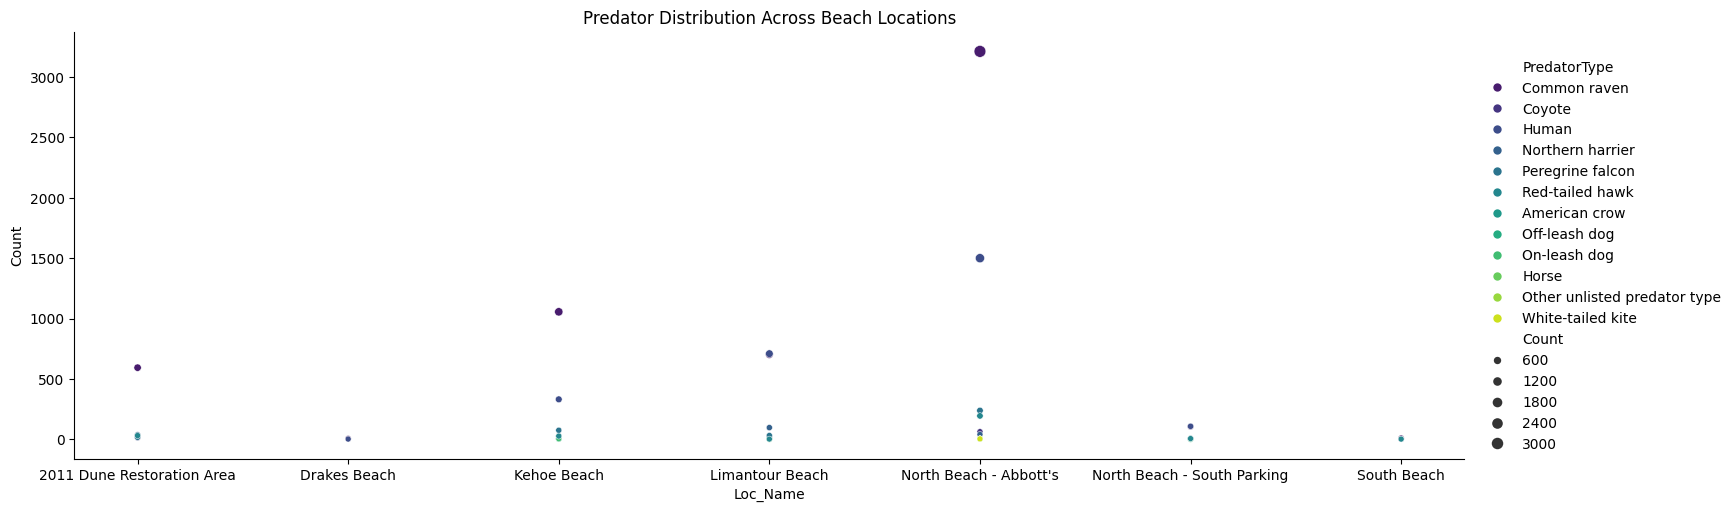

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

#using locations with the most predator observations

locations = merged_OP['Loc_Name'].value_counts().head(10).index
predator_df = merged_OP[merged_OP['Loc_Name'].isin(locations)]

predatorCount = predator_df.groupby(['Loc_Name', 'PredatorType']).size().reset_index(name='Count')

plt.figure(figsize=(10,6))
g = sns.relplot(
    data = predatorCount,
    x = 'Loc_Name',
    y = 'Count',
    hue = 'PredatorType',
    size = 'Count',
    palette = "viridis",
    aspect = 3
)
plt.title("Predator Distribution Across Beach Locations")

**2) What are the most common predator actions observed at different locations?**


*   Flying is the most common predator action across all beach locations
*   Walking predators are also frequently observed, specifically at Limantour Beach & Kehoe Beach
* Action patterns refelct type and intensity of predator pressure at each beach --> ML models can predict plover behavior since beaches with more active predator behaviors most likely have higher disturbance levels




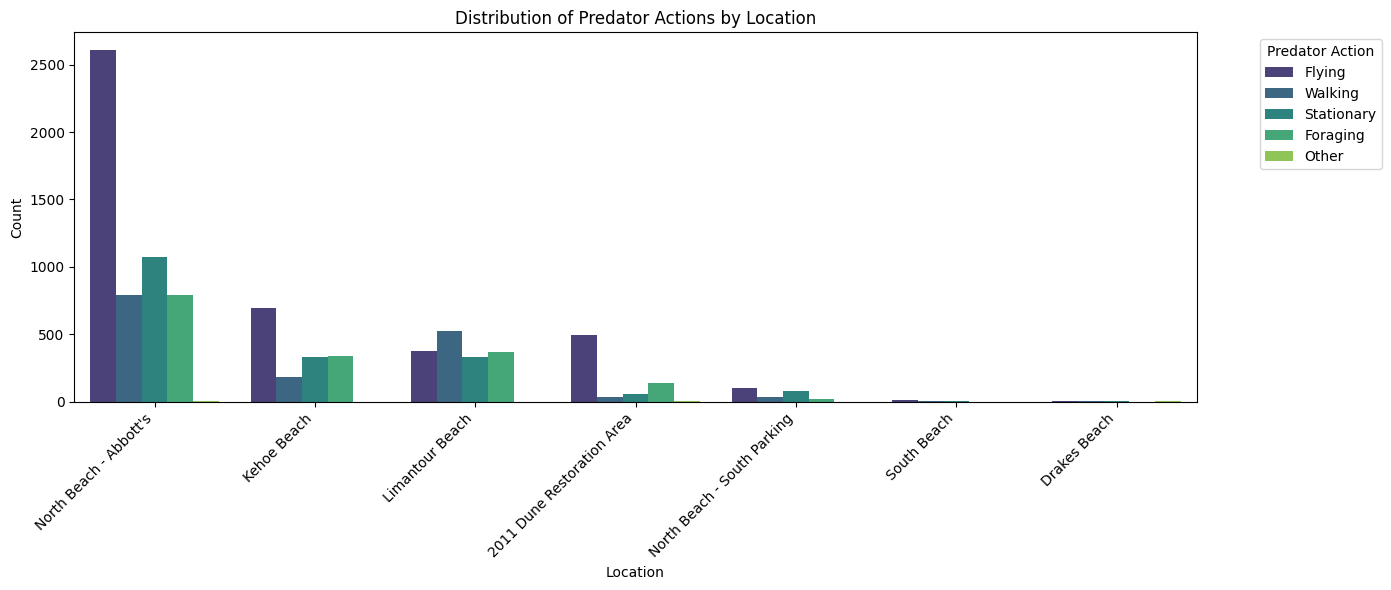

In [4]:
# make the PredatorAction string consistently capitalized
merged_OP['PredatorAction'] = merged_OP['PredatorAction'].map(lambda x: x.strip().capitalize() if pd.notnull(x) else x)

# make the plot
plt.figure(figsize=(14,6))
# x axis is the location name, the point is characterized by acrion, and ordered by the location value
sns.countplot(data = merged_OP, x = 'Loc_Name', hue = 'PredatorAction', order = merged_OP['Loc_Name'].value_counts().index, palette = 'viridis')
#rotate plot
plt.xticks(rotation = 45, ha = 'right')
plt.title('Distribution of Predator Actions by Location')
plt.xlabel('Location')
plt.ylabel('Count')
plt.legend(title = 'Predator Action', bbox_to_anchor = (1.05, 1), loc = 'upper left')
plt.tight_layout()
plt.show()

**3) How do male and female Snowy Plover counts vary across the most frequently observed locations?**


*   Across all top locations, male and female Snowy Plover counts are generally low, with most observations showing 0-5 individuals of each sex
*  Limantour Beach & Kehoe Beach show a wider spread of counts, including slightly higher female observations
* Overall pattern shows that sex ratios are similar across locations, which supports ML model prediciting plovers




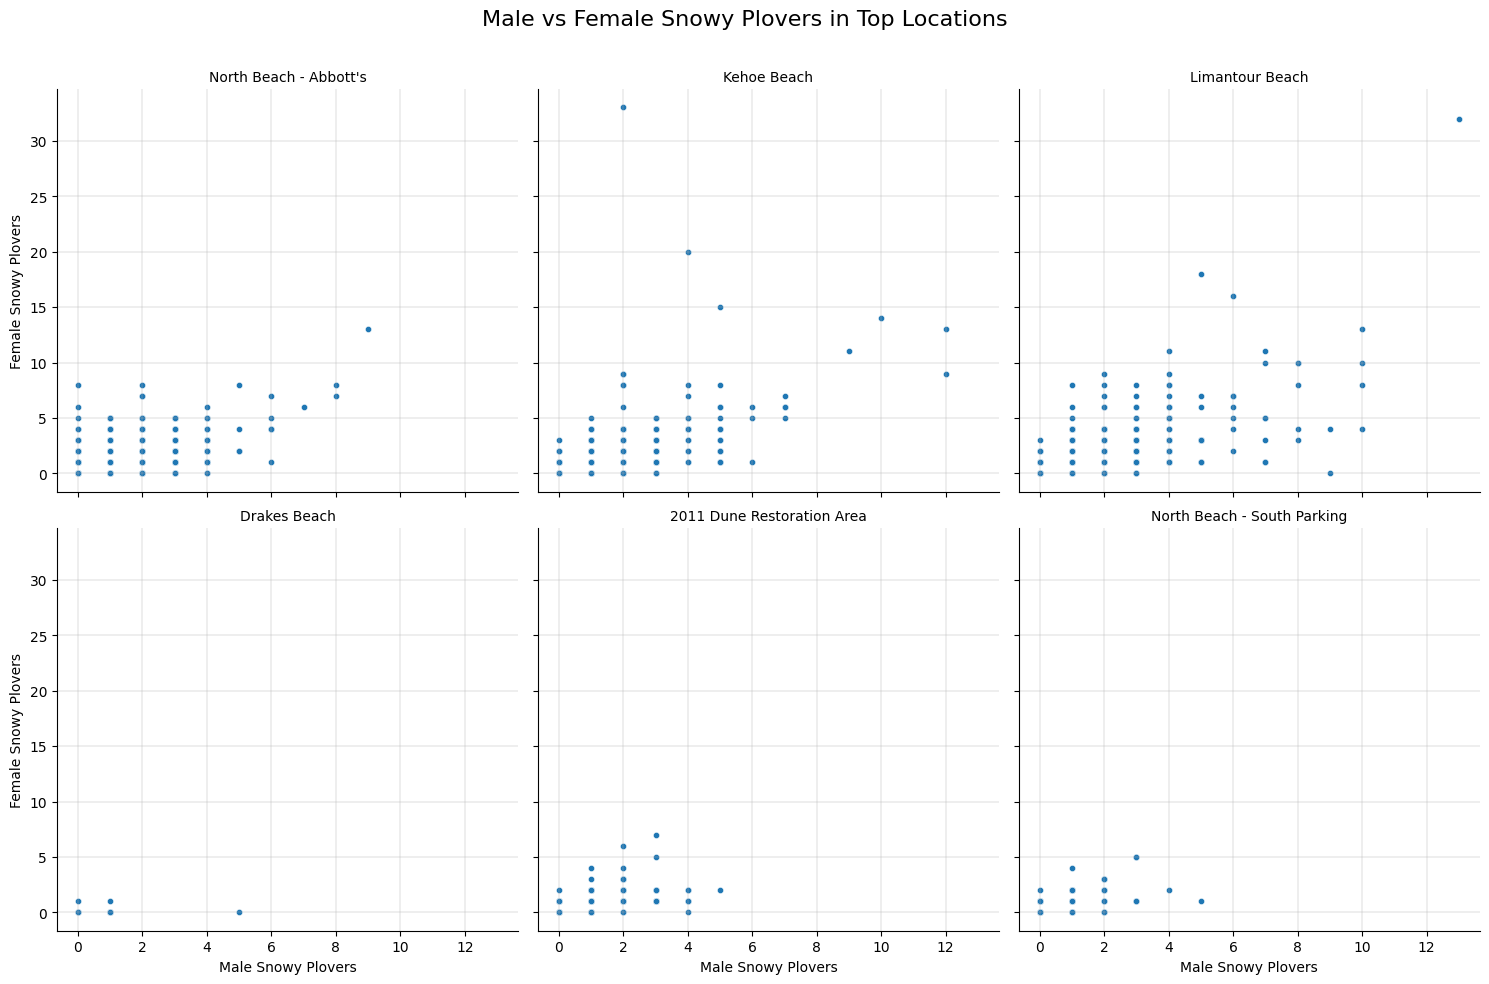

In [5]:
x_feature = "SNPL_Male"
y_feature = "SNPL_Female"
category  = "Loc_Name"

plot_df = merged_OP[[x_feature, y_feature, category]].dropna()

top_locs = plot_df[category].value_counts().head(6).index
plot_df = plot_df[plot_df[category].isin(top_locs)]


g = sns.FacetGrid(plot_df, col = category, col_wrap = 3, height = 5, sharex = True, sharey = True, palette = 'viridis')
g.map_dataframe(sns.scatterplot, x=x_feature, y=y_feature, s=20)

g.set_axis_labels("Male Snowy Plovers", "Female Snowy Plovers")
g.set_titles("{col_name}")
for ax in g.axes.flatten():
    ax.grid(True, linewidth=0.3)

plt.subplots_adjust(top=0.90)
g.fig.suptitle("Male vs Female Snowy Plovers in Top Locations", fontsize=16)
plt.show()

**4) What is the correlation between Snowy Plover counts and environmental/predator variables?**


*   Total_SNPL is strongly correlated with SNPL_Unk (0.91) and somewhat correlated with male and female
* Predator related variables show very weak correlations with plover counts, showing that predator presence alone does not predict number of plovers observed
* Low correlations between predator variables and plover counts show more features are needed in the ML model --> merge more data



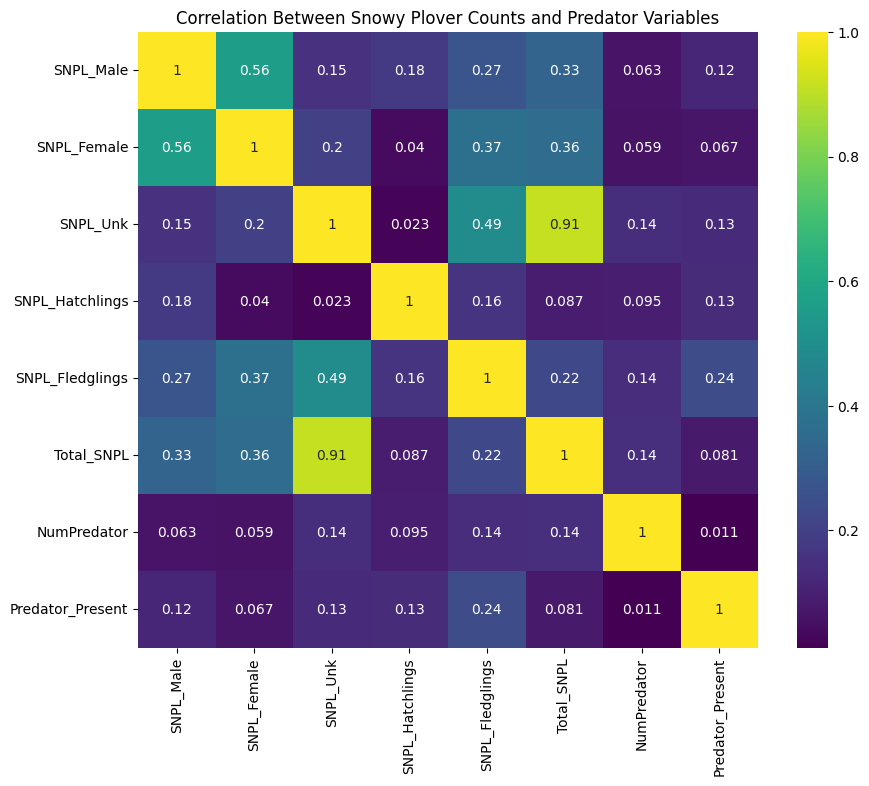

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_df = merged_OP[[
    "SNPL_Male",
    "SNPL_Female",
    "SNPL_Unk",
    "SNPL_Hatchlings",
    "SNPL_Fledglings",
    "Total_SNPL",
    "NumPredator",
    "Predator_Present"
]].copy()

# convert to int for correlation matrix
corr_df["Predator_Present"] = corr_df["Predator_Present"].astype(int)

plt.figure(figsize = (10,8))
sns.heatmap(corr_df.corr(), annot = True, cmap = "viridis")
plt.title("Correlation Between Snowy Plover Counts and Predator Variables")
plt.show()

**5) How does Snowy Plover activity change over breeding season?**


*   Snowy Plover activity is lowest between April and June, where average counts are 1.5-2 birds per observation, showing reduced visibility
*   Activity begins to increase in July, suggesting more breeding
* Highest average plover counts occur in September
* Seasonal pattern suggests that Month is an important predictive feature for modeling plover behavior



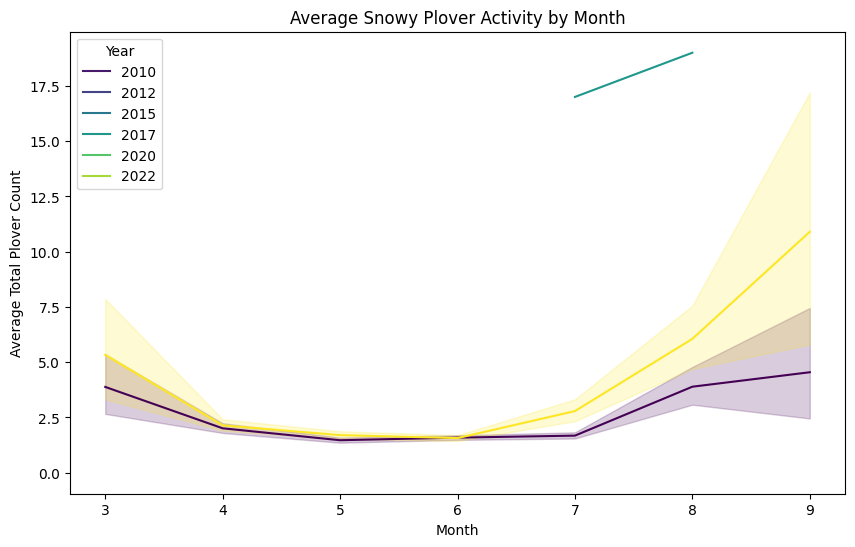

In [7]:
# Extract month
merged_OP["Month"] = merged_OP["Start_Date"].dt.month

plt.figure(figsize=(10,6))
sns.lineplot(
    data = merged_OP,
    x = "Month",
    y = "Total_SNPL",
    estimator = "mean",
    hue = "Year",
    palette = 'viridis'
)
plt.title("Average Snowy Plover Activity by Month")
plt.xlabel("Month")
plt.ylabel("Average Total Plover Count")
plt.show()


# Additional Exploration Models

In [8]:
#show missing data
merged_OP.isna().sum()

,0
ID,0
SNPL_Data_ID,0
Event_ID,0
Type,0
Basis_Of_Record,0
Unit_Code,0
Location_ID,0
Loc_Code,0
Loc_Name,0
Start_Year,0


Pairplot


*   Male, female, Unk, total are strongly related --> using all of these features are redudant so ML should avoid using all of them
*   Predator variables have weak relationships with plover counts --> needs to be combined with more data



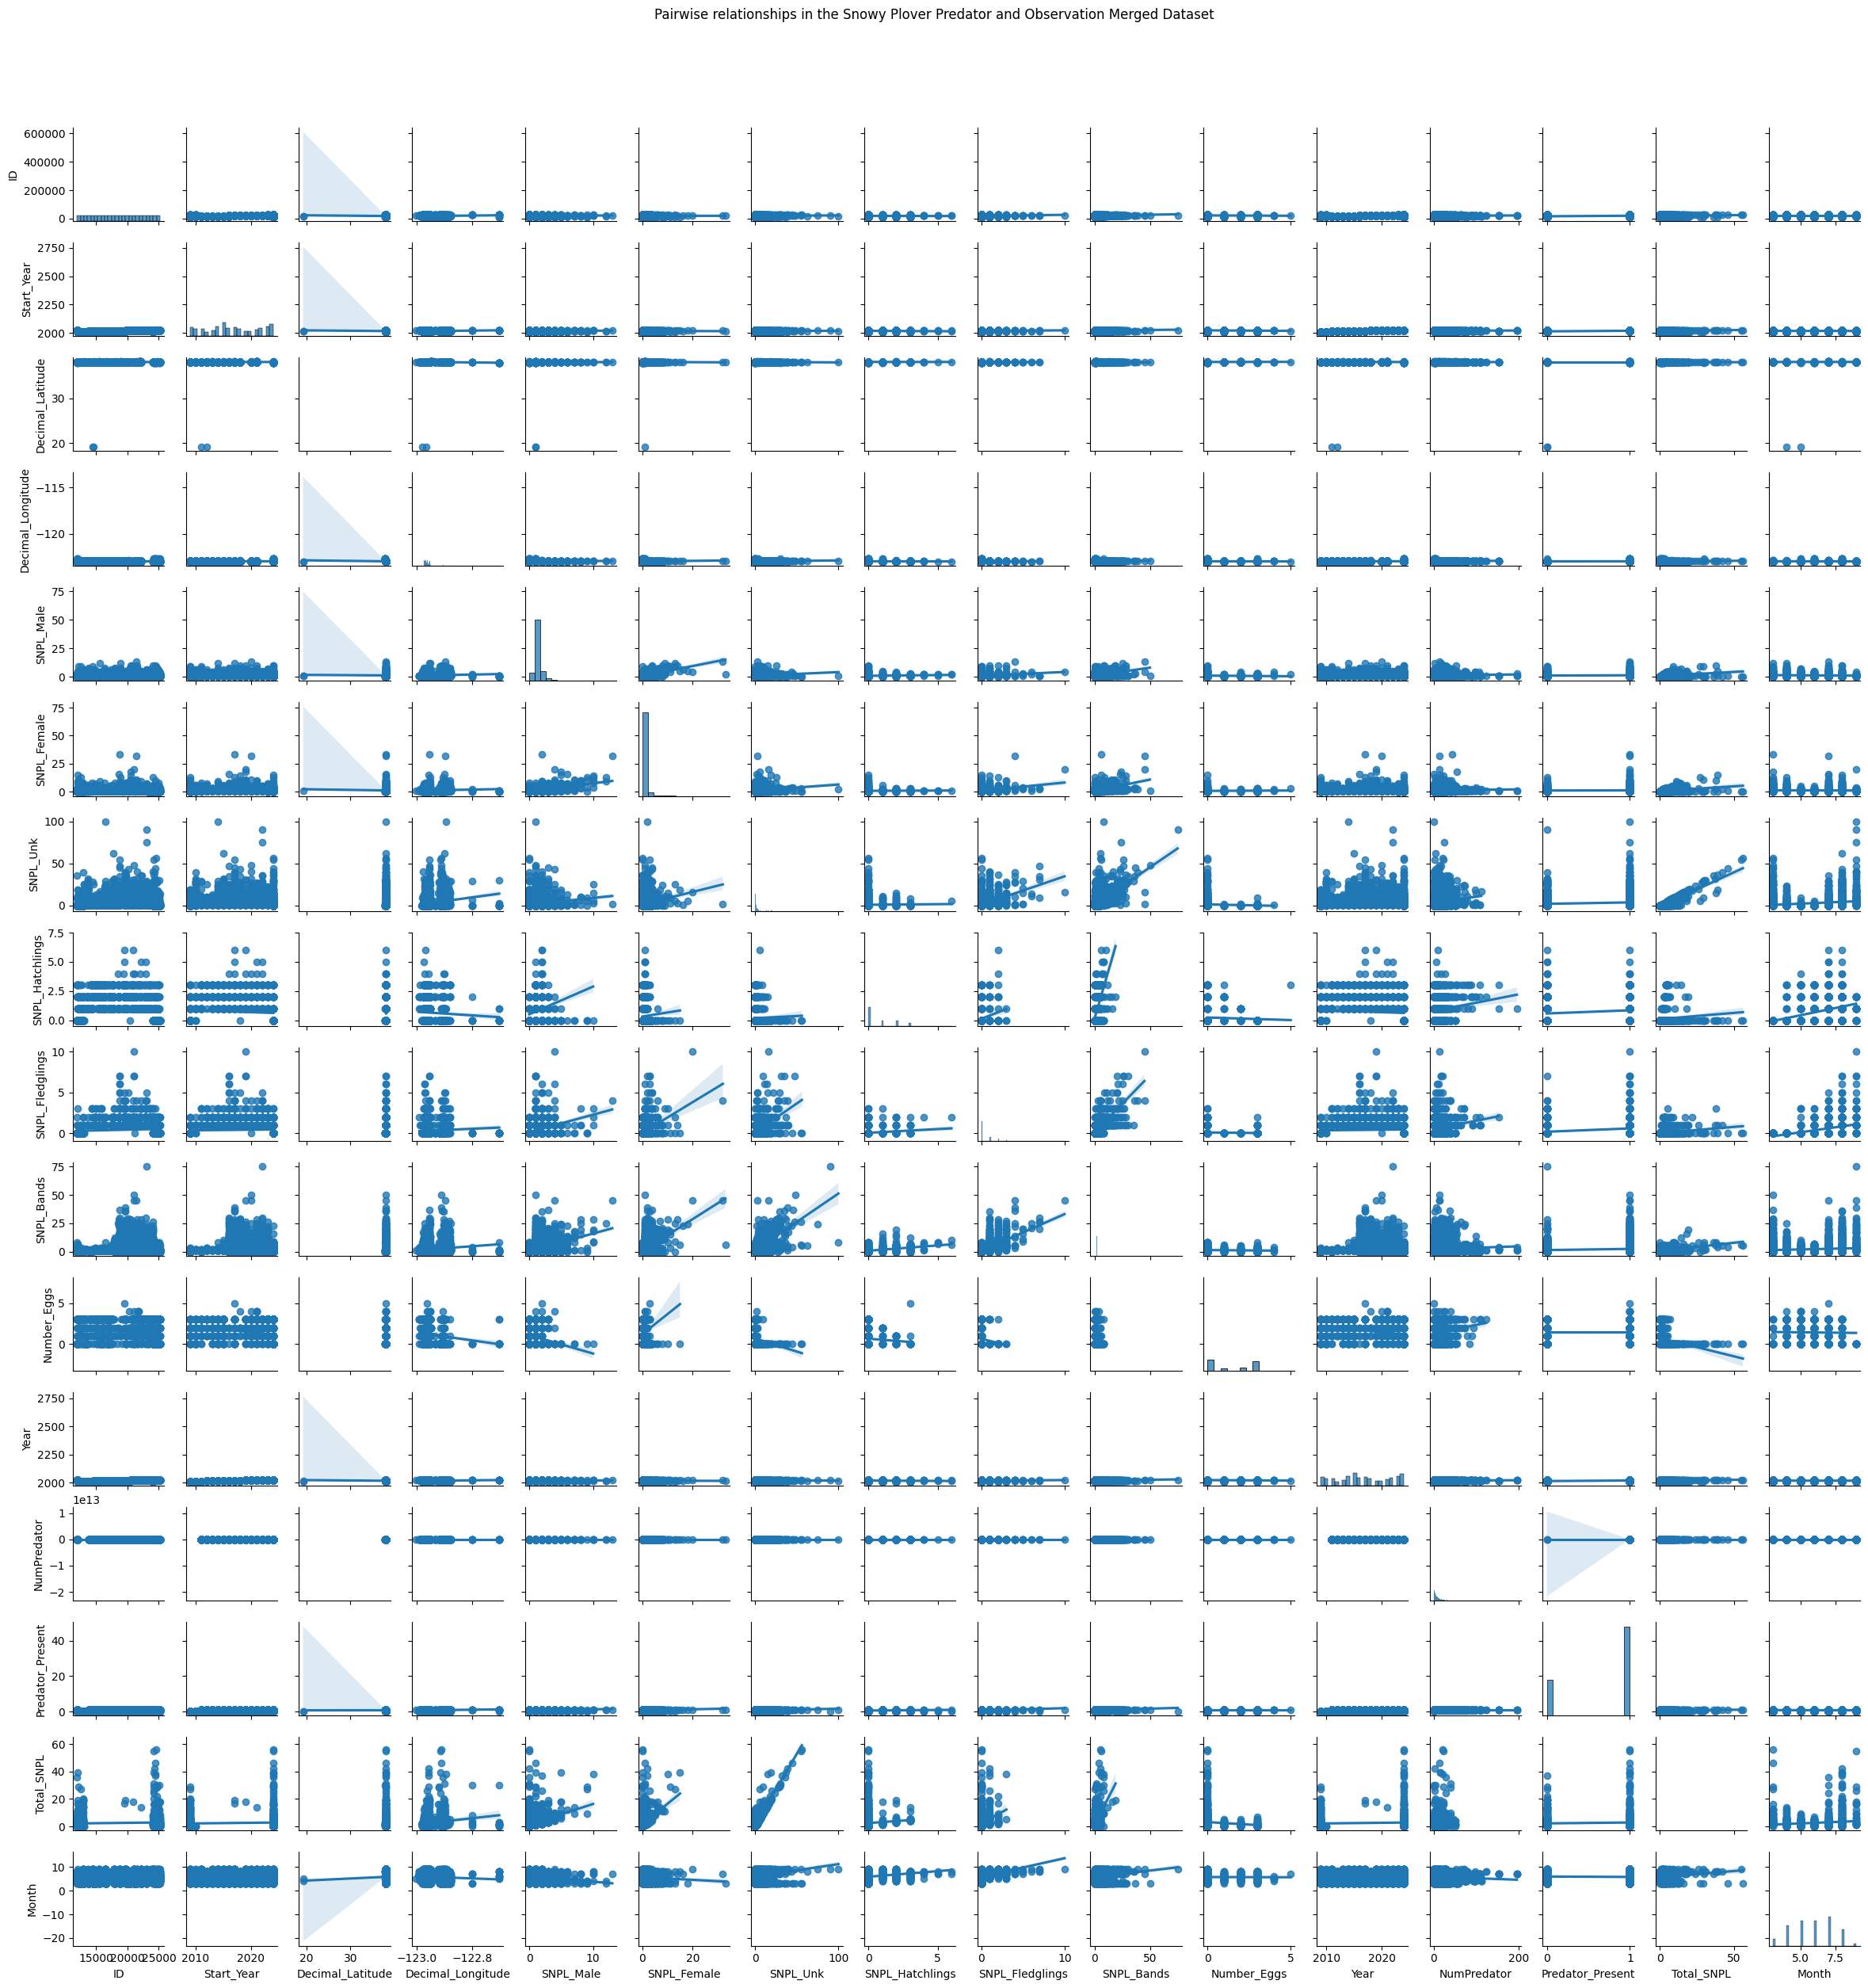

In [9]:
g=sns.pairplot(
    data=merged_OP,
    height=1.5,
    kind = "reg"
);
g.fig.suptitle(
    "Pairwise relationships in the Snowy Plover Predator and Observation Merged Dataset", y=1.05
);

#Saving merged_OP as a CSV

In [10]:
merged_OP.to_csv("/content/drive/MyDrive/Snowy Plover Datasets/merged_OP.csv", index=False)
